# Initialization

In [1]:
# Google Earth Engine packages
import ee
import geemap

# other packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#Define a function to plot the digital elevation model
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent)
    plt.colorbar(label=label)
    plt.grid()
    

# constants
ee_img = 'Image'
ee_ico = 'ImageCollection'

In [2]:
# initialize GEE at the beginning of session
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()         # authenticate when using GEE for the first time
    ee.Initialize()

In [3]:
import configparser
import ast

# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get file config from config.ini
dir_output = config['FILE_SETTINGS']['DIR_OUTPUT']
filename = dir_output + config['FILE_SETTINGS']['DEM_FILENAME']
output_gpkg = dir_output + config['FILE_SETTINGS']['GPKG_NAME']
download_rgi_dem = config.getboolean('FILE_SETTINGS','DOWNLOAD_RGI_DEM')

# get used GEE DEM and coords
dem = ast.literal_eval(config['CONFIG']['DEM'])
y, x = ast.literal_eval(config['CONFIG']['COORDS'])

# Start GEE and find catchment area

Start with base map

In [4]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Load selected DEM from GEE catalog and add as layer to map

In [5]:
if dem[0] == ee_img:
    image = ee.Image(dem[1])
elif dem[0] == ee_ico:
    image = ee.ImageCollection(dem[1]).select(dem[2]).mosaic()
    
srtm_vis = { 'bands': dem[2],
             'min': 0,
             'max': 6000,
            'palette': ['000000', '478FCD', '86C58E', 'AFC35E', '8F7131','B78D4F', 'E2B8A6', 'FFFFFF']
           }
Map.addLayer(image, srtm_vis, dem[3], True, 0.7)

Add configured discharge point to map and automatically draw box with 30km in all directions

In [6]:
point = ee.Geometry.Point(x,y)
Map.addLayer(point,{'color': 'blue'},'Discharge Point');

box = point.buffer(30000).bounds()
Map.addLayer(box,{'color': 'grey'},'Catchment Area', True, 0.7);
Map.centerObject(box, zoom=9)

Discharge point (marker) and box (polygon/rectangle) can be added manually to the map above. If features have been drawn, they will overrule the configured discharge point and automatically created box.

In [7]:
for feature in Map.draw_features:
    f_type = feature.getInfo()['geometry']['type']
    if f_type == 'Point':
        point = feature.geometry()
        print("Manually set pouring point will be considered")
    elif f_type == 'Polygon':
        box = feature.geometry()
        print("Manually drawn box will be considered")

Export DEM as .tif file to output folder.

In [8]:
geemap.ee_export_image(image, filename=filename, scale=30, region=box, file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to C:\Python\matilda_edu\output\dem_gee.tif


# Catchment deliniation

Use <code>pysheds</code> module to determine catchment area for discharge point. The result will be a raster.

In [9]:
# GIS packages
from pysheds.grid import Grid
import fiona

DEM_file = filename
# Plot the DEM
grid = Grid.from_raster(DEM_file)
dem = grid.read_raster(DEM_file)
grid.view(dem)
# Fill depressions in DEM
flooded_dem = grid.fill_depressions(dem)
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)
# Specify directional mapping
#N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
# Compute flow directions
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
#catch = grid.catchment(x=x, y=y, fdir=fdir, dirmap=dirmap, xytype='coordinate')
# Compute accumulation
acc = grid.accumulation(fdir)
# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))
# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')
# Clip the DEM to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

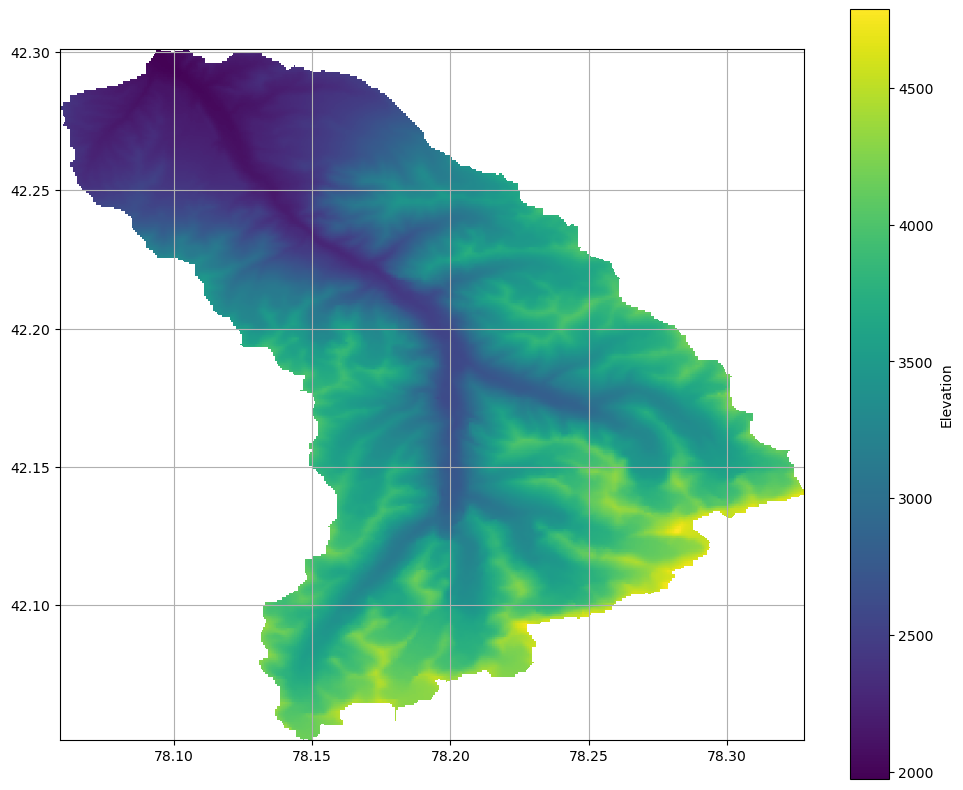

In [10]:
demView = grid.view(dem, nodata=np.nan)
plotFigure(demView,'Elevation')
plt.show()

Convert catchment raster to polygon and save to output folder as geopackage. 

In [11]:
from shapely.geometry import Polygon
import pyproj
from shapely.geometry import shape
from shapely.ops import transform

## Create shapefile and save it
shapes = grid.polygonize()

schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

catchment_shape = {}
with fiona.open(output_gpkg, 'w',
                #driver='ESRI Shapefile',#
                driver='GPKG',
                layer='catchment_orig',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        catchment_shape = shape
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1      

catchment_bounds = [int(np.nanmin(demView)),int(np.nanmax(demView))]
print(f"Catchment elevation is between {catchment_bounds[0]} m and {catchment_bounds[1]} m")
print(f"Mean catchment elevation is {str(np.nanmean(demView))} m")

Catchment elevation is between 1971 m and 4788 m
Mean catchment elevation is 3295.4766 m


Add catchment area to map and calculate area.

In [12]:
catchment = ee.Geometry.Polygon(catchment_shape['coordinates'])
Map.addLayer(catchment, {}, 'Catchment')

catchment_area = catchment.area().divide(1000*1000).getInfo()
print(f"Catchment area is {catchment_area} km²")

Catchment area is 295.3687037870257 km²


# Determine glaciers in catchment area

Find all glacier that are intersecting catchment area in RGI60 database (for area 13)

In [13]:
import geopandas as gpd

catchment = gpd.read_file(output_gpkg, layer='catchment_orig')
rgi = gpd.read_file("zip://input/13_rgi60_CentralAsia.zip")

if rgi.crs != catchment.crs:
    print("CRS adjusted")
    rgi = rgi.to_crs(catchment.crs)

rgi_catchment = gpd.sjoin(rgi,catchment,how='inner',predicate='intersects')

CRS adjusted


Some glaciers do not belong to catchment but are intersecting the derived catchment area. Therefore, the percentage of the glacier will be calculated to determine whether glacier will be part of catchment or not (>=50% of its area needs to be in catchment). Glaciers outside catchment with overlapping area will reduce catchment area.
Results for each glacier can be printed if needed.

In [14]:
# intersects selects too many. calculate percentage of glacier area that is within catchment
rgi_catchment['rgi_area'] = rgi_catchment.area

gdf_joined = gpd.overlay(catchment,rgi_catchment, how='union')
gdf_joined['area_joined'] = gdf_joined.area
gdf_joined['share_of_area'] = (gdf_joined['area_joined'] / gdf_joined['rgi_area'] * 100)

results = (gdf_joined
           .groupby(['RGIId','LABEL_1'])
           .agg({'share_of_area':'sum'}))

#print(results.sort_values(['share_of_area'],ascending=False))

In [15]:
rgi_catchment = pd.merge(rgi_catchment, results, on="RGIId")
rgi_in_catchment = rgi_catchment.loc[rgi_catchment['share_of_area'] >= 50]
rgi_out_catchment = rgi_catchment.loc[rgi_catchment['share_of_area'] < 50]

catchment_new = gpd.overlay(catchment, rgi_out_catchment, how='difference')
catchment_new = gpd.overlay(catchment_new, rgi_in_catchment, how='union')
catchment_new = catchment_new.dissolve()[['LABEL_1','geometry']]
catchment_new['area'] = catchment_new.to_crs("+proj=cea +lat_0=35.68250088833567 +lon_0=139.7671 +units=m")['geometry'].area
print(f"New catchment area is {catchment_new.iloc[0]['area']/1000/1000} km²")

New catchment area is 295.27634765003506 km²


Export data to existing geopackage:
<ul>
    <li>RGI glaciers within catchment</li>
    <li>RGI glaciers outside catchment</li>
    <li>Adjusted catchment area based in RGI glaciers</li>
</ul>

In [16]:
rgi_in_catchment.to_file(output_gpkg, layer='rgi_in', driver='GPKG')
rgi_out_catchment.to_file(output_gpkg, layer='rgi_out', driver='GPKG')
catchment_new.to_file(output_gpkg, layer='catchment_new', driver='GPKG')

Add determined glaciers and new catchment area to map.

In [17]:
c_new = geemap.geopandas_to_ee(catchment_new)
Map.addLayer(c_new, {'color': 'orange'}, "Catchment New")

rgi = geemap.geopandas_to_ee(rgi_in_catchment)
Map.addLayer(rgi, {'color': 'white'}, "RGI60")

The thickness of each glacier must be determined from raster files. Depending on the RGI IDs that are within catchment area, the corresponding raster files will be downloaded from server and stored in output folder.
The thinkness raster files will be supported by DEM raster files for easier processing. They will also be extracted from a large zip file.

In [18]:
### TEMP ###

import geopandas as gpd

output_folder = 'output/'

rgi_in_catchment = gpd.read_file('output/catchment_data.gpkg', layer='rgi_in')
catchment_new = gpd.read_file('output/catchment_data.gpkg', layer='catchment_new')

In [19]:
rgiids = rgi_in_catchment['RGIId'].sort_values()

areas = []
file_names_thickness = []
file_names_dem = []
for rgiid in rgiids:
    # prepare filename that will be checked in *.zip archive in the next step
    file_names_thickness.append(f'{rgiid}_thickness.tif')
    file_names_dem.append(f'surface_DEM_{rgiid}.tif')
    area = rgiid.split('.')[0]
    if area not in areas: areas.append(area)

# Retrieve raster files for thickness and corresponding DEM raster files

Start with thinkness: download from server and extract tif files

In [20]:
import requests
from zipfile import ZipFile
import io

# download and extract thinkness raster files from server
cnt_thickness = 0
for area in areas:
    url = f'https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/315707/composite_thickness_{area}.zip?sequence=15&isAllowed=y'
    r = requests.get(url, stream=True)

    with ZipFile(io.BytesIO(r.content), 'r') as zipObj:
        # Get a list of all archived file names from the zip
        listOfFileNames = zipObj.namelist()
        for fileName in listOfFileNames:
            file = fileName.split('/')[1]
            if file in file_names_thickness:
                cnt_thickness += 1
                zipObj.extract(fileName, output_folder+'RGI')
print(f'{cnt_thickness} files have been extracted (ice thickness)')

38 files have been extracted (ice thickness)


Try to download DEM archive from server. Since archive has large file size, it might be uploaded manually. The download must be activated in <code>config.ini</code>

In [21]:
if(download_rgi_dem):
    print("Downloading file...")
    
    # try to get DEM from server (large file size, might take some time)
    url = f'https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/315707/surface_DEMs_RGI60.zip?sequence=65&isAllowed=y'
    r = requests.get(url, stream=True)

    with ZipFile(io.BytesIO(r.content), 'r') as zipObj:
        # Get a list of all archived file names from the zip
        listOfFileNames = zipObj.namelist()
        for area in areas:
            fileName = f'surface_DEMs_{area}.zip'
            if fileName in listOfFileNames:
                zipObj.extract(fileName, output_folder)
            else:
                print(f'No DEM archive found for area {area}') 
else:
    print("No file download")

No file download


Extract DEM tif files from archive

In [22]:
# extract DEM raster files from archive (previously downloaded or uploaded)
cnt_dem = 0
for area in areas:
    with ZipFile(output_folder + f'surface_DEMs_{area}.zip', 'r') as zipObj:
        # Get a list of all archived file names from the zip
        listOfFileNames = zipObj.namelist()
        for fileName in listOfFileNames:
            if fileName in file_names_dem:
                cnt_dem += 1
                zipObj.extract(fileName, output_folder+'RGI/DEM/')
print(f'{cnt_dem} files have been extracted (DEM)')


38 files have been extracted (DEM)


# Glacier profile creation
Overlay ice thickness and DEM tif for each glacier to create tuples

In [23]:
from osgeo import gdal

df_all = pd.DataFrame()
if cnt_thickness != cnt_dem:
    print('Number of thickness raster files does not match number of DEM raster files!')
else:
    for idx,rgiid in enumerate(rgiids):
        if rgiid in file_names_thickness[idx] and rgiid in file_names_dem[idx]:
            file_list = [
                output_folder + 'RGI/RGI60-13/' + file_names_thickness[idx],
                output_folder + 'RGI/DEM/' + file_names_dem[idx]
            ]
            array_list = []

            # Read arrays
            for file in file_list:
                src = gdal.Open(file)
                geotransform = src.GetGeoTransform() # Could be done more elegantly outside the for loop
                projection = src.GetProjectionRef()
                array_list.append(src.ReadAsArray())
                pixelSizeX = geotransform[1]
                pixelSizeY =-geotransform[5]                
                src = None
            
            df = pd.DataFrame()
            df['thickness'] = array_list[0].flatten()
            df['altitude'] = array_list[1].flatten()
            df_all = df_all.append(df)
        else:
            print(f'Raster files do not match for {rgiid}')

Remove all points with zero ice thickness and aggregate all points to 10m elevation zones.

Export result as CSV file

In [24]:
if len(df_all) > 0:
    df_all = df_all.loc[df_all['thickness'] > 0]
    df_all.sort_values(by=['altitude'],inplace=True)
    
    # get min/max altitude considering catchment and all glaciers
    alt_min = 10*int(min(catchment_bounds[0],df_all['altitude'].min())/10)
    alt_max = max(catchment_bounds[1],df_all['altitude'].max())+10
    
    # create bins in 10m steps
    bins = np.arange(alt_min, df_all['altitude'].max()+10, 10)
    
    # aggregate per bin and do some math
    df_agg = df_all.groupby(pd.cut(df_all['altitude'], bins))['thickness'].agg(count='size', mean='mean').reset_index()
    df_agg['elevation'] = df_agg['altitude'].apply(lambda x: x.left)
    df_agg['area'] = df_agg['count']*pixelSizeX*pixelSizeY / catchment_new.iloc[0]['area']
    df_agg['WE'] = df_agg['mean']*0.908*1000
    df_agg['EleZone'] = df_agg['elevation'].apply(lambda x: 100*int(x/100))
    
    # delete empty elevation bands but keep at least one entry per elevation zone
    df_agg=pd.concat([df_agg.loc[df_agg['count']>0],
                      df_agg.loc[df_agg['count']==0].drop_duplicates(['EleZone'],keep='first')]
                    ).sort_index()
    
    df_agg.drop(['altitude'], axis=1, inplace=True)
    df_agg.to_csv(output_folder + 'glacier_profile.csv', header=True, index=False)
    print('Glacier profile for catchment successfully created !')

Glacier profile for catchment successfully created !
